In [1]:
# !pipenv install cleverhans==2.1.0
# !pip install matplotlib==2.2.2

In [2]:
import tensorflow as tf
import cleverhans
import numpy as np
import matplotlib.pyplot as plt
import keras
import pprint as pp
from PIL import Image
from keras.preprocessing import image
from cleverhans.utils_tf import model_eval
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.attacks import FastGradientMethod
%matplotlib inline 
sess = tf.Session()
keras.backend.set_session(sess)
init = tf.global_variables_initializer()
sess.run(init)
cleverhans.__version__

Using TensorFlow backend.


'2.0.0-8d4c955f2a5a269a78a612198cf754a4'

In [3]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')
for l in model.layers:
    l.trainable = False

img_path = 'DSC_0897.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n03792972', 'mountain_tent', 0.7340291), ('n09472597', 'volcano', 0.10711667), ('n09468604', 'valley', 0.06280205)]


In [4]:
#from keras.applications.resnet50 import ResNet50
# model = ResNet50(weights='imagenet')

In [5]:
def load_image(extension: str):
  img_path = f'{extension}.jpg'
  img = image.load_img(img_path, target_size=(224, 224))
  plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  return x

In [6]:
# !wget https://github.com/GANs-in-Action/gans-in-action/raw/Chapter-10/chapter-10/DSC_0897.jpg
# !wget https://github.com/GANs-in-Action/gans-in-action/raw/Chapter-10/chapter-10/DSC_0896.jpg

[('n03792972', 'mountain_tent', 0.7340291),
 ('n09472597', 'volcano', 0.10711667),
 ('n09468604', 'valley', 0.06280205),
 ('n09193705', 'alp', 0.047732376),
 ('n09246464', 'cliff', 0.011990498),
 ('n09399592', 'promontory', 0.0072744703),
 ('n04366367', 'suspension_bridge', 0.0064715287),
 ('n09332890', 'lakeside', 0.002592583),
 ('n04417672', 'thatch', 0.0025826134),
 ('n02980441', 'castle', 0.0021615697),
 ('n03160309', 'dam', 0.0013809014),
 ('n02859443', 'boathouse', 0.0009619669),
 ('n09428293', 'seashore', 0.0007863976),
 ('n04507155', 'umbrella', 0.0006721237),
 ('n04346328', 'stupa', 0.0006369705),
 ('n02951358', 'canoe', 0.00061166874),
 ('n04532670', 'viaduct', 0.00054790766),
 ('n03028079', 'church', 0.0005021455),
 ('n02361337', 'marmot', 0.00048321288),
 ('n03792782', 'mountain_bike', 0.00039575153)]
Predicted: None


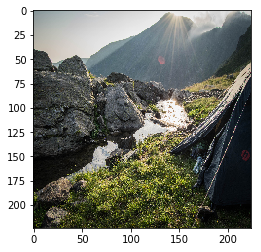

In [7]:
img1 = load_image("DSC_0897")
# img1 = img1 / 255.0
preds = model.predict(x)
print('Predicted:', pp.pprint(decode_predictions(preds, top=20)[0]))

## Currently the code resets the session, so the network is initialized with empty weights? 
-> Sense check fails and gibberish predictions are returned

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

[('n01930112', 'nematode', 0.11369576),
 ('n03041632', 'cleaver', 0.025615493),
 ('n03729826', 'matchstick', 0.022331195),
 ('n03838899', 'oboe', 0.022105629),
 ('n03476684', 'hair_slide', 0.022037566),
 ('n04270147', 'spatula', 0.020252394),
 ('n03804744', 'nail', 0.019513916),
 ('n02783161', 'ballpoint', 0.018827388),
 ('n02804610', 'bassoon', 0.017519291),
 ('n03109150', 'corkscrew', 0.0135526685),
 ('n03207941', 'dishwasher', 0.01285324),
 ('n02667093', 'abaya', 0.01152646),
 ('n04380533', 'table_lamp', 0.011245237),
 ('n04154565', 'screwdriver', 0.010771998),
 ('n02951585', 'can_opener', 0.01031067),
 ('n04153751', 'screw', 0.010163832),
 ('n04266014', 'space_shuttle', 0.01016269),
 ('n03400231', 'frying_pan', 0.010118216

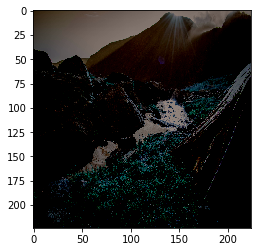

In [8]:
w_model = KerasModelWrapper(model)
fgsm = FastGradientMethod(w_model, sess=sess)

# x = tf.convert_to_tensor(img1)
fgsm_params = {'eps': 0.001,
               'clip_min': 0.,
               'clip_max': 1.,
               'ord': 1}
img1 = load_image('DSC_0897')
img1 = img1 / 255.0
adv_x_np = fgsm.generate_np(img1, y=preds, **fgsm_params)
pic = adv_x_np * .01 + .99 * img1
# Consider the attack to be constant
adv_x2 = tf.stop_gradient(adv_x_np)
adv_x = tf.convert_to_tensor(adv_x_np)
# model = ResNet50(weights='imagenet')
preds_adv = model(adv_x2)
numeric_preds = preds_adv.eval(session=sess)
print('Predicted:', pp.pprint(decode_predictions(numeric_preds, top=20)[0]))


corrected_image2 = adv_x.eval(session=sess)[0,:,:,:]
plt.imshow(corrected_image2)

In [14]:
pic.min()

-0.48016942

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


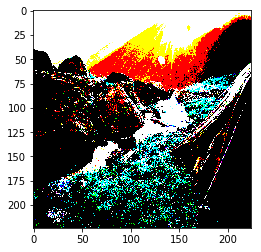

In [10]:
corrected_image3 = 127.5 * corrected_image2
plt.imshow(corrected_image3)

In [ ]:
corrected_image2 = adv_x2.eval(session=sess)[0,:,:,:]
plt.imshow(corrected_image2)

In [ ]:
# pic = pic + 127.5
plt.imshow(pic[0,:,:,:])

In [ ]:
adv_x_np

In [ ]:
preds2 = model.predict(img2)
print('Predicted:', pp.pprint(decode_predictions(preds2, top=20)[0]))

In [ ]:
with sess.as_default():
  print_op = tf.print(preds_adv)
  with tf.control_dependencies([print_op]):
    adv_x = fgsm.generate(x, **fgsm_params)
    # Consider the attack to be constant
    adv_x = tf.stop_gradient(adv_x)
    preds_adv = model(adv_x)
  sess.run(preds_adv)

In [ ]:
img2 = load_image("DSC_0896")